<a href="https://colab.research.google.com/github/zhong338/MFM-FM5222/blob/main/Week4_CustomDists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom distribution is scipy.stats

Suppose you want to work with a family of distributions but it's not built in to scipy.stats.  If you can define the pdf, you can use class function to work with the distribution.

We will demonstrate first with an example where we create the class for a "mynorm".



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [ ]:
class mynorm(ss.rv_continuous):

    def _pdf(self, x):

        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)


In [ ]:
norm_test = mynorm()  # this makes the instance of distribution which we can use

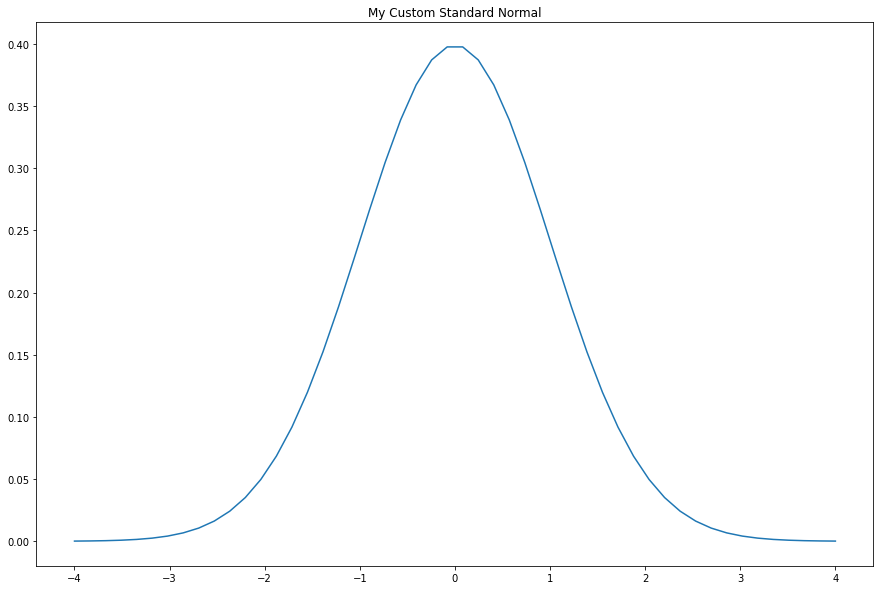

In [ ]:
#let's plot

x = np.linspace(-4,4)

plt.figure(figsize = (15,10))

plt.plot(x, norm_test.pdf(x))

plt.title("My Custom Standard Normal")

plt.show()

### Location and Scale are "built in" to this class

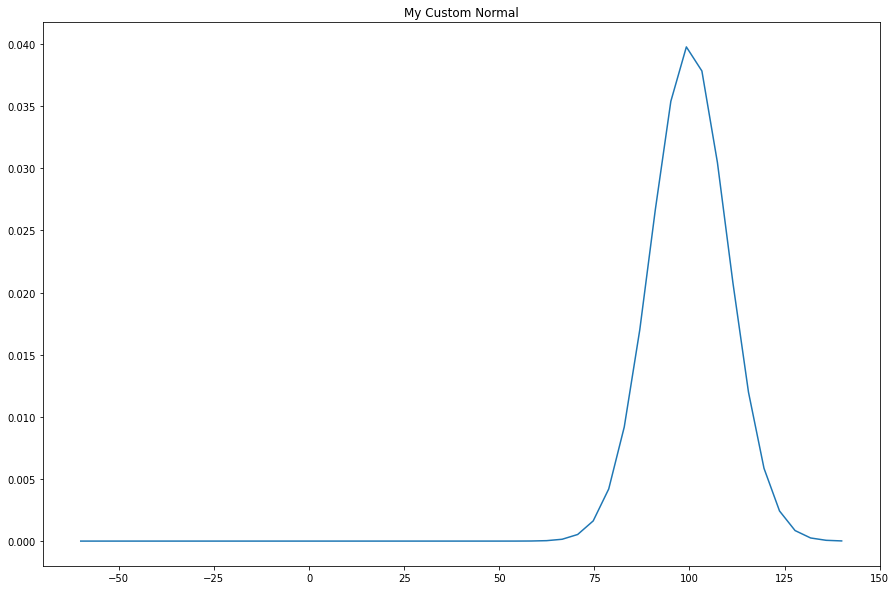

In [ ]:
#let's plot

x = np.linspace(-60,140)

plt.figure(figsize = (15,10))

plt.plot(x, norm_test.pdf(x, loc= 100, scale = 10))

plt.title("My Custom Normal")

plt.show()

Even though we didn't define the other methods, most of them will still work because scipy.stats knows what to do with the pdf.  For example, cdf

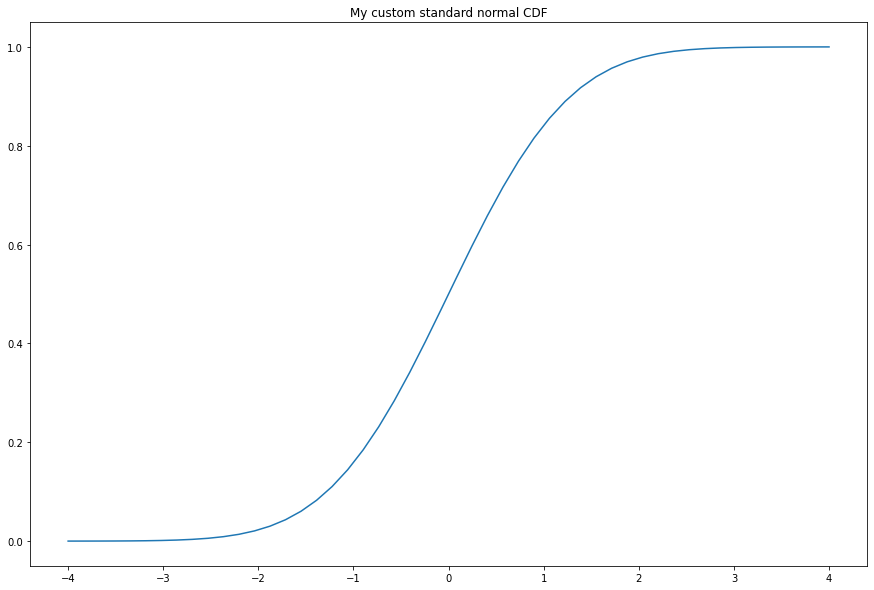

In [ ]:
x = np.linspace(-4,4)

plt.figure(figsize = (15,10))

plt.plot(x, norm_test.cdf(x))

plt.title("My custom standard normal CDF")

plt.show()

In [ ]:
# We can invert this (It's done numerically)
norm_test.ppf(.95)

1.6448536269516416

In [ ]:
# We can ask it for moments.  Note it takes a bit becaues it is numerically integrating.
norm_test.stats(loc = 51, scale = 5,  moments='mvsk')

(array(51.), array(24.99999998), array(-2.87114718e-15), array(6.61551391e-09))

These should be 51, 5, 0 and 0 (excess kurtosis).










## Something that doesn't already exist.

Let's make a mixture PDF.

Here, we take a mixture of two normal distributions.

In [ ]:
class mymix(ss.rv_continuous ):

    def _argcheck(self, *args):
        return True # super()._argcheck(*args)

    def _pdf(self, x, m1, s1,m2, s2, p):

        return p*ss.norm.pdf(x, loc = m1, scale = s1) + (1-p)* ss.norm.pdf(x, loc =m2, scale = s2)



In [ ]:
mixture = mymix() # We have to instantiate



Like before, we can plot this. We will do it for some diffent choices of $p$.

We will set, $\mu_1 = 0, \sigma_1 = 1, \mu_2 =10, \sigma_2 = 4$ 

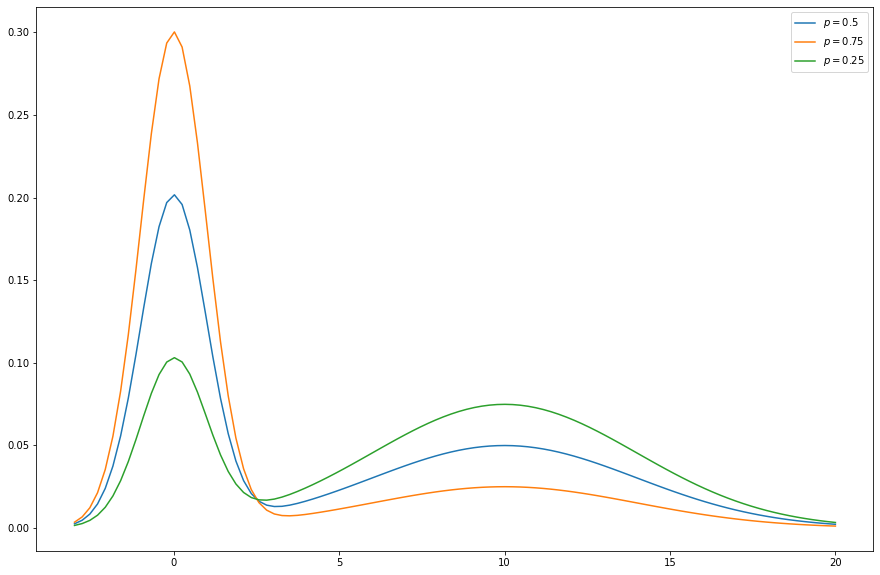

In [ ]:
x = np.linspace(-3,20, 100)

plt.figure(figsize = (15,10))

plt.plot(x, mixture.pdf(x, m1 = 0, s1 = 1, m2 = 10, s2 = 4, p = .5), label = "$p=0.5$")

plt.plot(x, mixture.pdf(x, m1 = 0, s1 = 1, m2 = 10, s2 = 4, p = .75), label = "$p=0.75$")

plt.plot(x, mixture.pdf(x, m1 = 0, s1 = 1, m2 = 10, s2 = 4, p = .25), label = "$p=0.25$")



plt.legend()

plt.show()

Many the methods can be overwritten by the user. The main reason to do this would be to speed things up or improve numerical accuracy.  Here are some issues an manifested with out custom mix. 



In [ ]:
 mixture.rvs(size = 100, m1 = 0, s1 = 1, m2 = 10, s2 = 4, p = .75)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:180: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C


RuntimeError: ignored

This is basically happening because the means are two far apart and the numerical invervions are suffering.   We "fix" this by moving the mean closer to together to illustrate that (as is), rvs is just slow

In [ ]:
%time  test = mixture.rvs(size = 100, m1 = 0, s1 = 1, m2 = 2, s2 = 4, p = .75)

CPU times: user 1min 7s, sys: 1.74 s, total: 1min 9s
Wall time: 1min 8s


The better fix is too overwrite the rvs method with something already optimized.

In [ ]:
class mymix(ss.rv_continuous ):

    def _argcheck(self, *args):
        return True # super()._argcheck(*args)

    def _pdf(self,x, m1, s1,m2, s2, p):

        return p*ss.norm.pdf(x, loc =m1, scale = s1) + (1-p)* ss.norm.pdf(x, loc =m2, scale = s2)


    def _rvs(self, m1, s1,m2, s2, p):

        choice = ss.binom.rvs(size = self._size, n=1, p = p)

    

        return  ss.norm.rvs( size = self._size, loc =m1, scale = s1)* choice +  ss.norm.rvs(size = self._size, loc =m2, scale = s2)* (1-choice) 

In [ ]:
mixture = mymix()


In [ ]:
%time  test = mixture.rvs(size = 100, m1 = 0, s1 = 1, m2 = 2, s2 = 4, p = .75)

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 1.88 ms


And we fixed the other issue as well.

In [ ]:
test = mixture.rvs(size = 1000, m1 = 0, s1 = 1, m2 = 10, s2 = 4, p = .75)

Now let's generate a bigger set and use the fit method.  We are gong to set the location and scale becuase otherwies, the optimization will have a locus of points (location and scale are redundant here).

In [ ]:
mixture.fit(test, floc = 0, fscale = 1)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


(9.688263441082618,
 3.959006016998001,
 -0.02321126503143099,
 1.0177599412164935,
 0.23927889969300653,
 0,
 1)

We can see the estimate is quite good, but it took a long time. 